# Create fake data from a given model and covariance

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 160
mpl.rcParams['figure.dpi'] = 160
from cup1d.data import data_Chabanier2019
from cup1d.data import data_Karacayli2022
from cup1d.data import data_QMLE_Ohio
from cup1d.data import mock_data
from lace.emulator import nn_emulator

/home/jchaves/miniconda3/envs/py11/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# setup data to mimic, with a maximum z to avoid redshifts not emulated
#data_label="Chabanier2019"
data_label="QMLE_Ohio"
zmin=2.0
zmax=4.5
if data_label=="Chabanier2019":
    data=data_Chabanier2019.P1D_Chabanier2019(zmin=zmin,zmax=zmax)
elif data_label=="Karacayli2022":
    data=data_Karacayli2022.P1D_Karacayli2022(zmin=zmin,zmax=zmax)
elif data_label=="QMLE_Ohio":
    data=data_QMLE_Ohio.P1D_QMLE_Ohio(zmin=zmin,zmax=zmax)

will read P1D file /home/jchaves/Proyectos/projects/lya/chains//private_data/p1d_measurements//QMLE_Ohio//desi-y5fp-1.5-4-o3-deconv-power-qmle_kmax0.04.txt
2 low-k bins not included


 /home/jchaves/Proyectos/projects/lya/cup1d/cup1d/data/data_QMLE_Ohio.py:67: FutureWarning:The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead


In [3]:
emu_params=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
training_set = 'Cabayol23'
if(training_set):
    emulator_label = "Cabayol23"
    emu_path = "NNmodels/Cabayol23/Cabayol23.pt"
    drop_sim_val = None
    pre_trained = True
    use_GP=False
    
if(pre_trained):
    emulator = nn_emulator.NNEmulator(
        training_set=training_set,
        emulator_label=emulator_label,
        emu_params=emu_params,
        model_path=emu_path,
        drop_sim=drop_sim_val,
        train=False,
    )    
else:
    if use_GP:
        emulator=gp_emulator.GPEmulator(training_set=training_set,emu_params=emu_params)
    else:
        # these might be sub-optimal settings for the Nyx emulator
        emulator=nn_emulator.NNEmulator(training_set=training_set,emu_params=emu_params)

Selected emulator Cabayol23
Samples in training_set: 9900
Selected emulator Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Model loaded. No training needed


In [4]:
mock=mock_data.Mock_P1D(data_label=data_label, emulator=emulator, zmin=zmin, zmax=zmax)

will read P1D file /home/jchaves/Proyectos/projects/lya/chains//private_data/p1d_measurements//QMLE_Ohio//desi-y5fp-1.5-4-o3-deconv-power-qmle_kmax0.04.txt
2 low-k bins not included


 /home/jchaves/Proyectos/projects/lya/cup1d/cup1d/data/data_QMLE_Ohio.py:67: FutureWarning:The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead


In [5]:
keys = ['label','marker','data'] 
datasets = [dict(zip(keys,['data','*',data])),
            dict(zip(keys,['mock','.',mock]))]

In [6]:
def combined_plot(datasets,zmin=1.7,zmax=6.0,kmin=0.001,kmax=0.1):
    Ndata=len(datasets)
    for idata in range(Ndata):
        label=datasets[idata]['label']
        marker=datasets[idata]['marker']
        data=datasets[idata]['data']
        k_kms=data.k_kms
        kplot=(k_kms>kmin) & (k_kms<kmax)
        k_kms=k_kms[kplot]
        zs=data.z
        Nz=len(zs)
        for iz in range(Nz):
            z=zs[iz]
            if z < zmin: continue
            if z > zmax: continue
            Pk_kms=data.get_Pk_iz(iz)[kplot]
            err_Pk_kms=np.sqrt(np.diagonal(data.get_cov_iz(iz)))[kplot]    
            fact=k_kms/np.pi
            plt.errorbar(k_kms,fact*Pk_kms,
                         marker=marker,ms=4.5,ls="none",
                         yerr=fact*err_Pk_kms,
                         label=label+' z = {}'.format(z))
    plt.legend()
    plt.yscale('log', nonpositive='clip')
    plt.xscale('log')
    plt.ylabel(r'$k P(k)/ \pi$')

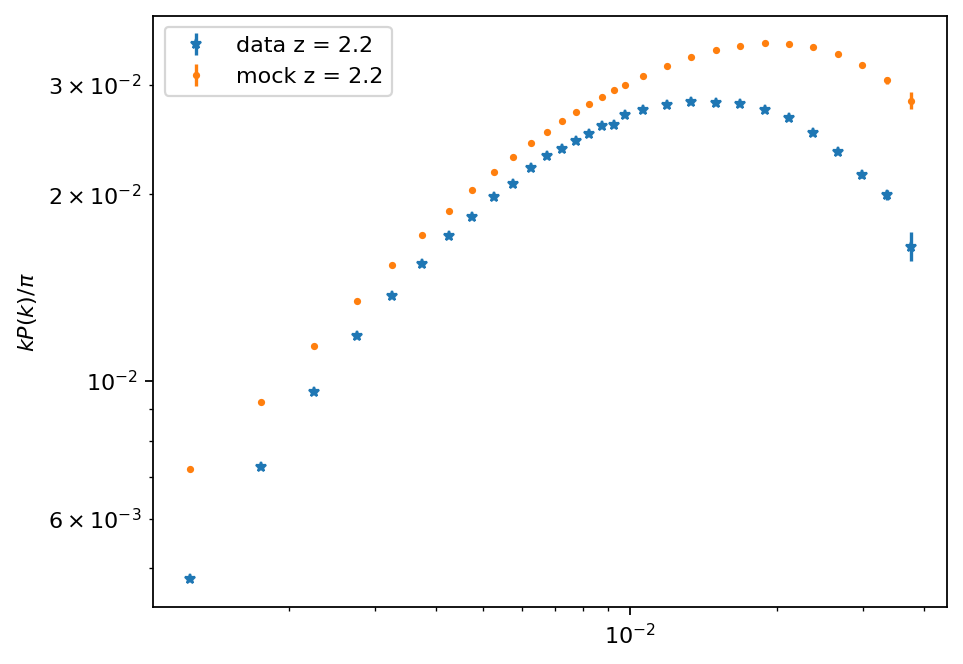

In [7]:
combined_plot(datasets,zmin=2.05,zmax=2.25,kmax=0.05)

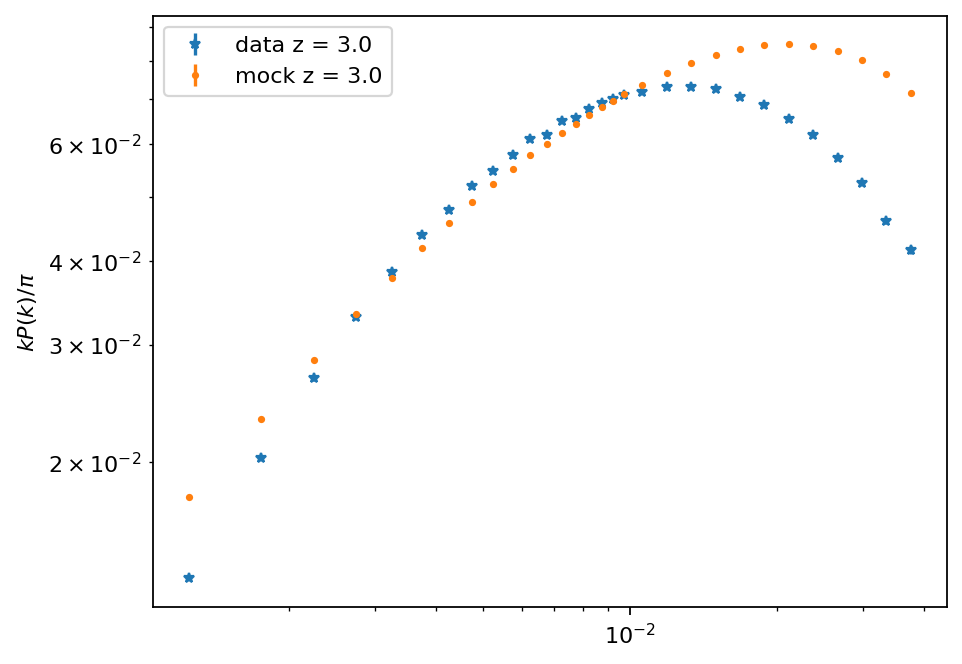

In [8]:
combined_plot(datasets,zmin=2.9,zmax=3.1,kmax=0.05)

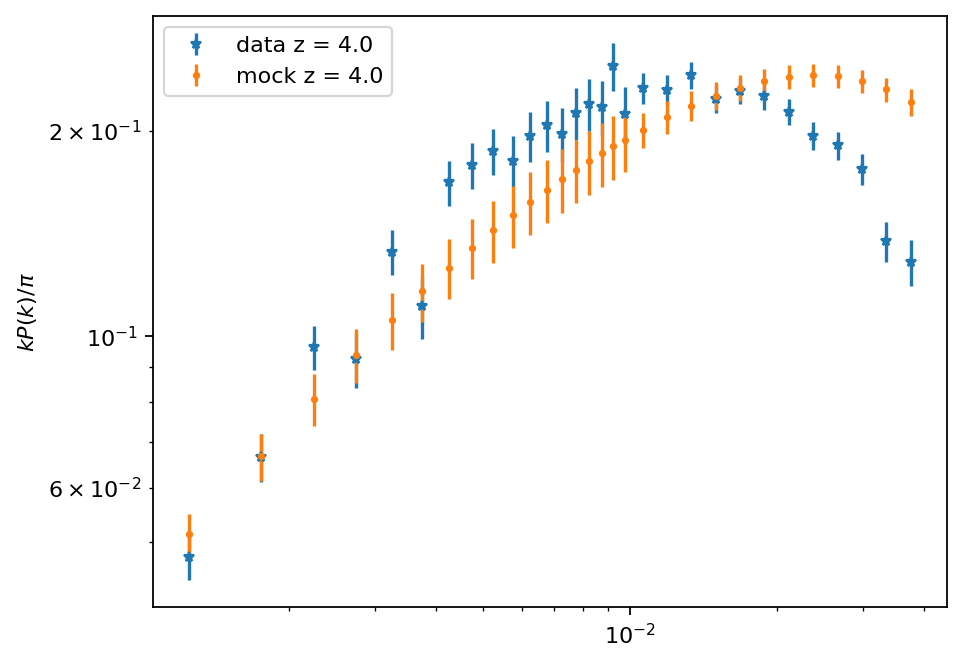

In [10]:
combined_plot(datasets,zmin=3.9,zmax=4.1,kmax=0.05)